In [17]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from tqdm import tqdm

# Notes
1. Here we calculate uncertainty for each individual group of trees. These calculations to not appropriately account for stratification; we should expect that stratifying will reduce variance of each subpopulation and hence reduce uncertainty

## 0. read in data, make helper function

In [45]:
raw = pd.read_csv('kentland_10_22.csv', index_col=0)
raw = pd.read_csv('../../data/raw/wt_kentland_data.csv', index_col=0)
raw = raw[['tree_id', 'species', 'diam_app (cm)', 'biomass_kg', 'biomass_tonnes', 'biomass_TCO2e']]
raw.head()

,tree_id,species,diam_app (cm),biomass_kg,biomass_tonnes,biomass_TCO2e
date,,,,,,
10/17/22 15:57,8DA11D43-FE57-45BB-AABE-E3080236DD36,Black Walnut,38.956627,903.857107,0.903857,1.491364
10/17/22 15:59,3C922067-605B-4D88-9C59-AD9C79F0EF81,Black Walnut,41.863015,1085.396100,1.085396,1.790904
10/17/22 16:01,514070F0-2FA5-44C3-8AC7-E768856BED28,Black Walnut,33.907506,634.967563,0.634968,1.047696
10/17/22 16:08,DCCFED1A-22DF-488D-8C32-D9A27549A6CC,Black Walnut,26.331809,333.744987,0.333745,0.550679
10/17/22 16:10,0621C0F8-4F08-442B-BC72-3B34F138FD3C,Black Walnut,22.634581,227.129053,0.227129,0.374763


In [46]:
def get_unc(measurements, alpha):
    n = len(measurements)
    df = n - 1
    t = sps.t.ppf(1-alpha/2, df)

    var = measurements.var() / n
    mean = measurements.mean()

    return t*np.sqrt(var)/mean

In [47]:
alpha = 0.1
sps.t.ppf(1-alpha/2, 10)

1.8124611228107335

## 1. Summary: uncertainty by measurement type

In [48]:
summ = {}
device = [col for col in raw.columns if not col in ['tree_id', 'species']]
for d in device:
    measurements = raw[d].loc[raw[d].notna()].values
    summ[d] = [len(measurements), measurements.mean(), measurements.var(), get_unc(measurements, alpha)]

summ = pd.DataFrame(summ).T.reset_index()
summ.columns = ['measurement', 'n', 'mean', 'variance', 'uncertainty']
summ

,measurement,n,mean,variance,uncertainty
0,diam_app (cm),107.0,25.070647,30.091836,0.0351
1,biomass_kg,107.0,337.485167,31602.740184,0.0845
2,biomass_tonnes,107.0,0.337485,0.031603,0.0845
3,biomass_TCO2e,107.0,0.556851,0.086038,0.0845


In [49]:
sps.t.ppf(1-alpha/2, len(measurements)) * np.sqrt(measurements.var() / len(measurements)) / measurements.mean()

0.08449277727028959

## 2. Summary: uncertainty by measurement type and species

In [50]:
species = raw.species_x.unique()[:2]

AttributeError: 'DataFrame' object has no attribute 'species_x'

In [53]:
summ = {}
device = [col for col in raw.columns if not col in ['tree_id', 'species']]
for d in device:
    for s in species:
        measurements = raw[d].loc[(raw.species == s) & (raw[d].notna())].values
        summ[(d, s)] = [len(measurements), get_unc(measurements, alpha)]

summ = pd.DataFrame(summ).T.reset_index()
summ.columns = ['measurement', 'species', 'n', 'uncertainty']
summ

,measurement,species,n,uncertainty
0,diam_app (cm),Honey Locust,57.0,0.042668
1,diam_app (cm),Black Walnut,50.0,0.041165
2,biomass_kg,Honey Locust,57.0,0.105915
3,biomass_kg,Black Walnut,50.0,0.105709
4,biomass_tonnes,Honey Locust,57.0,0.105915
5,biomass_tonnes,Black Walnut,50.0,0.105709
6,biomass_TCO2e,Honey Locust,57.0,0.105915
7,biomass_TCO2e,Black Walnut,50.0,0.105709


## 3. Summary: Uncertainty by num samples

In [56]:
n_bootstraps = 500
min_sample = 5
devices = [col for col in raw.columns if not col in ['tree_id', 'species']]
summ = {d:{} for d in device}

In [57]:
for b in tqdm(range(n_bootstraps)):
    for d in devices:
        measurements = raw[d].loc[raw[d].notna()].values
        n = len(measurements)
        for i in range(min_sample, n):
            idxs = np.random.choice(np.arange(n), size=i, replace=True)
            if i not in summ[d].keys():
                summ[d][i] = [get_unc(measurements[idxs], alpha)]
            else:
                summ[d][i] += [get_unc(measurements[idxs], alpha)]

100%|██████████| 500/500 [00:48<00:00, 10.26it/s]


### Bootstrapped uncertainty calculations
**Note:** Distribution comes from repeating the uncertainty calculation 500 times for the given number of measurements

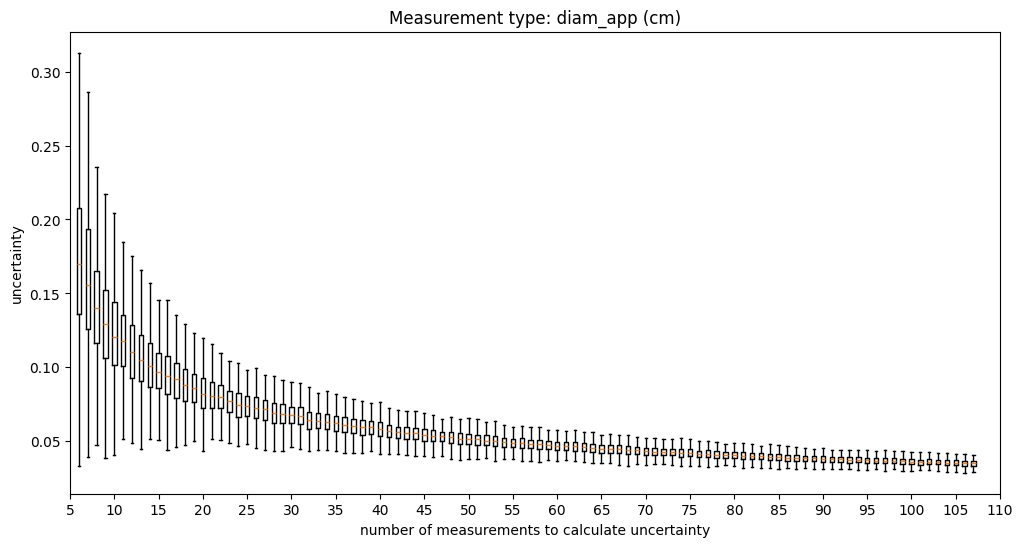

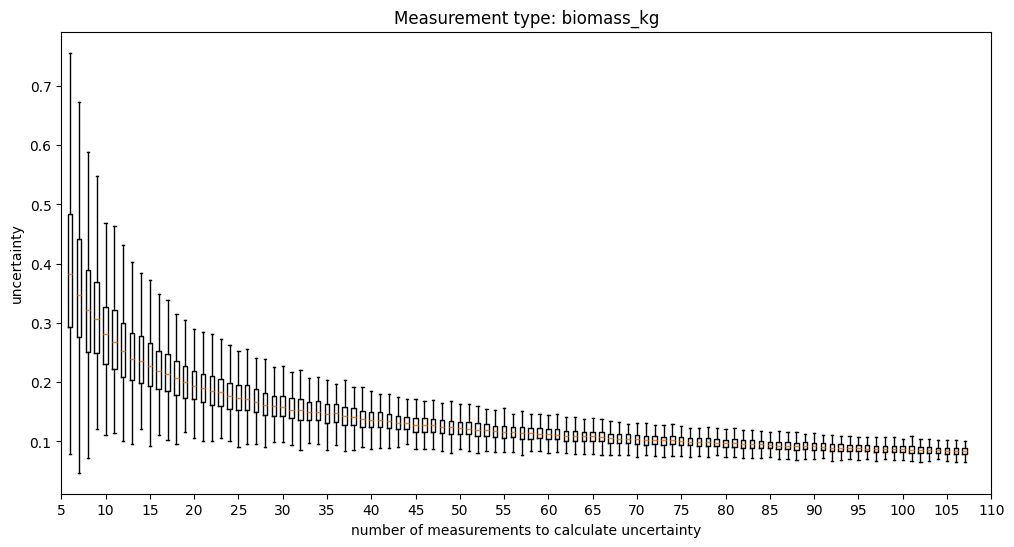

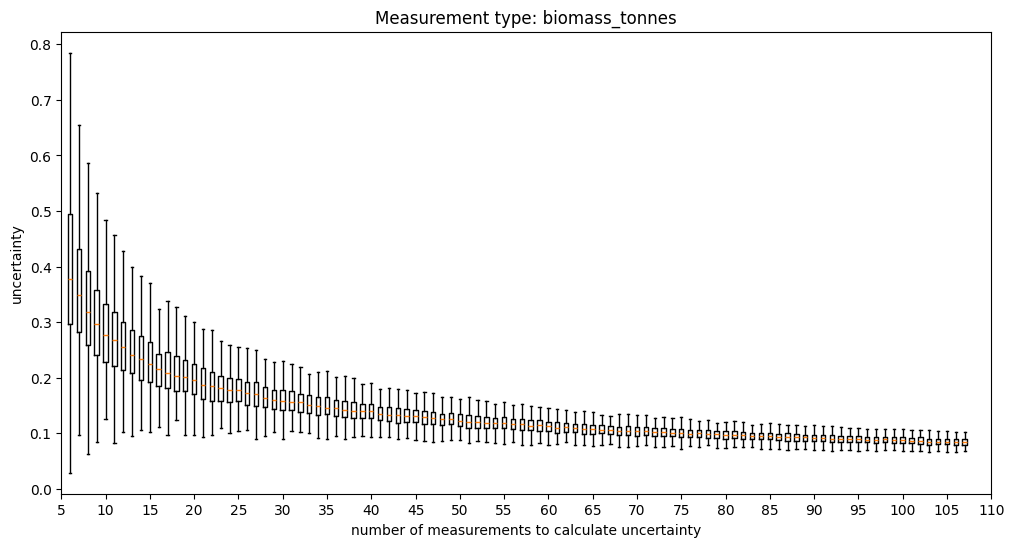

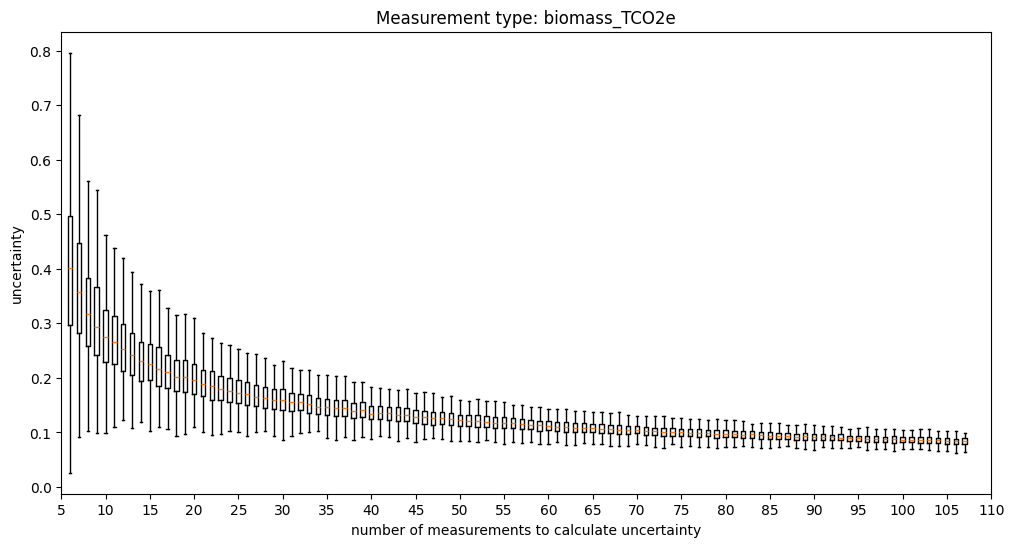

In [58]:
for d in devices:
    dev = summ[d]
    n = len(dev.keys())
    plt.figure(figsize=(12, 6))
    plt.boxplot(list(dev.values()), vert=True, labels=list(dev.keys()), showfliers=False)
    plt.xticks(ticks=range(0, n+5, 5), labels=range(min_sample, n+min_sample+5, 5))
    plt.title(f'Measurement type: {d}')
    plt.xlabel('number of measurements to calculate uncertainty')
    plt.ylabel('uncertainty')
    plt.show()